<a href="https://colab.research.google.com/github/mfonseca2810/Inteligencia-Artificial-MAFB-/blob/main/Detector_de_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detector de SPAM**

Creadores:
- Laura Prada
- Manuel Fonseca

Importación de Librerías:
- pandas/numpy: manejo de datos; matplotlib: gráfica del balance de clases (equivale a countplot)
- scikit-learn: vectorización TF-IDF, modelos y métricas
- nltk: stopwords + lematización; usaremos fallbacks si no hay internet
- gensim: LDA (si no está disponible, hacemos fallback a sklearn-LDA)

In [33]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

1. CARGA Y EDA

- Cargamos spam.csv en latin-1 (típico de esta versión del dataset)
- Renombramos columnas crípticas (v1→etiqueta, v2→texto)
- Eliminamos columnas sobrantes y filas vacías

Interpretación
- El dataset NO está balanceado (hay más "ham" que "spam").
- Por eso, la métrica de "accuracy" puede ser engañosa (un modelo que casi siempre diga "ham"
- Puede tener exactitud alta pero no detectar spam; en producción priorizamos Recall en spam).

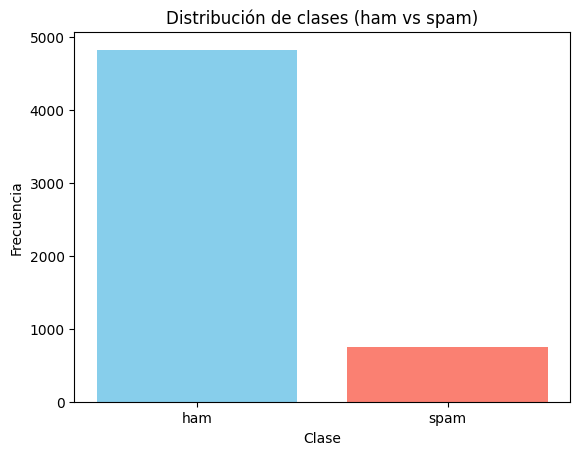

Mensajes ham: 4825, Mensajes spam: 747
Dataset desbalanceado → accuracy puede ser engañosa (priorizar recall para spam).


In [34]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'etiqueta', 'v2': 'texto'})[['etiqueta', 'texto']].dropna()

conteo = df['etiqueta'].value_counts()
plt.bar(conteo.index, conteo.values, color=['skyblue', 'salmon'])
plt.title('Distribución de clases (ham vs spam)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

print(f"Mensajes ham: {conteo['ham']}, Mensajes spam: {conteo['spam']}")
print("Dataset desbalanceado → accuracy puede ser engañosa (priorizar recall para spam).")

2. PREPROCESAMIENTO

- Convierte a minúsculas.
- Elimina puntuación y números.
- Tokeniza las palabras.
- Elimina **Stop Words**.
- Aplica **Lematización (WordNetLemmatizer)**.
- Crea una nueva columna `texto_limpio`.

In [35]:
try:
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

try:
    STOP_EN = set(stopwords.words('english'))
except Exception:
    STOP_EN = set("""
    i me my myself we our ours ourselves you your yours yourself yourselves
    he him his himself she her hers herself it its itself they them their theirs themselves
    what which who whom this that these those am is are was were be been being have has had
    do does did doing a an the and but if or because as until while of at by for with about
    against between into through during before after above below to from up down in out on
    off over under again further then once here there when where why how all any both each
    few more most other some such no nor not only own same so than too very can will just
    don should now
    """.split())

try:
    LEM = WordNetLemmatizer()
except Exception:
    class Dummy:
        def lemmatize(self, w, pos='n'): return w
    LEM = Dummy()

token_pat = re.compile(r"[A-Za-z]+")

def preprocess_text(text):
    toks = token_pat.findall(str(text).lower())
    toks = [w for w in toks if w not in STOP_EN]
    toks = [LEM.lemmatize(w) for w in toks]
    return " ".join(toks)

df['texto_limpio'] = df['texto'].apply(preprocess_text)

3. VECTORIZACIÓN + MODELADO

- Etiqueta binaria: ham=0, spam=1
- TF-IDF con uni- y bi-gramas; min_df=2 para reducir ruido
- Split 80/20 estratificado para mantener proporción de clases
- Dos modelos clásicos para texto corto:
  - MultinomialNB: muy eficiente en bag-of-words/TF-IDF
  - LogisticRegression: suele mejorar Recall/Balance con TF-IDF
- Entrenamos y evaluamos cada modelo


=== MultinomialNB ===
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115


=== LogisticRegression ===
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.72      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



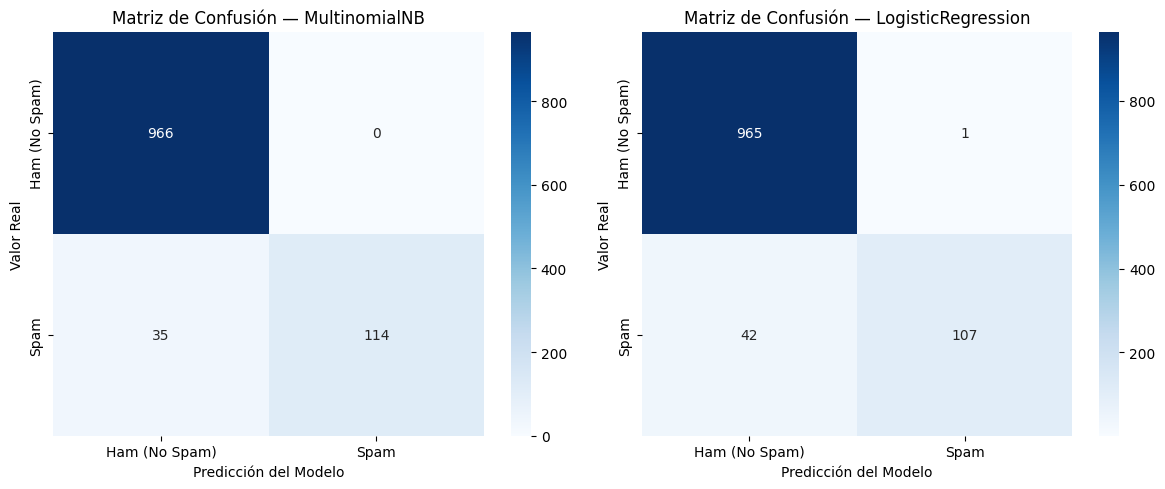

In [36]:
X, y = df['texto_limpio'], df['etiqueta'].map({'ham': 0, 'spam': 1}).astype(int)

vec = TfidfVectorizer(min_df=2, ngram_range=(1, 2))
Xv = vec.fit_transform(X)

Xtr, Xte, ytr, yte = train_test_split(Xv, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = {}

for name, m in models.items():
    m.fit(Xtr, ytr)
    y_pred = m.predict(Xte)
    print(f"\n=== {name} ===\n", classification_report(yte, y_pred, target_names=['ham', 'spam']))
    cm = confusion_matrix(yte, y_pred)
    results[name] = {'model': m, 'cm': cm}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
labels = ['Ham (No Spam)', 'Spam']

for ax, (name, result) in zip(axes, results.items()):
    sns.heatmap(result['cm'], annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"Matriz de Confusión — {name}")
    ax.set_xlabel("Predicción del Modelo")
    ax.set_ylabel("Valor Real")

plt.tight_layout()
plt.show()

4. ANÁLISIS DE TÓPICOS

- Sobre los textos que el modelo clasifica como spam, extraer 4 tópicos

- Primero intentamos con gensim; si no está disponible, hacemos fallback a sklearn LDA.

Tópicos

- Tópico 1: Promociones y sorteos
- Tópico 2: Premios y reclamaciones
- Tópico 3: Mensajes automatizados
- Tópico 4: Ofertas y servicios telefónicos

In [37]:
best = results['LogisticRegression']['model']
pred_all = best.predict(Xv)
spam_mask = (pred_all == 1)
spam_texts = df.loc[spam_mask, 'texto_limpio'].tolist()

if not spam_texts:
    print("No hay textos de spam para análisis de tópicos.")
else:
    try:
        from gensim.corpora import Dictionary
        from gensim.models import LdaModel
        toks = [t.split() for t in spam_texts if t]
        D = Dictionary(toks)
        C = [D.doc2bow(d) for d in toks]
        lda = LdaModel(corpus=C, id2word=D, num_topics=4, random_state=42, passes=5)
        print("\n=== Tópicos principales en SPAM (gensim LDA) ===")
        for i in range(4):
            print(f"Tópico {i+1}:", lda.print_topic(i))

    except Exception:
        from sklearn.decomposition import LatentDirichletAllocation
        cv = CountVectorizer(min_df=2, max_df=0.9)
        Xs = cv.fit_transform(spam_texts)
        lda = LatentDirichletAllocation(n_components=4, random_state=42, learning_method='batch', max_iter=20)
        lda.fit(Xs)
        vocab = np.array(cv.get_feature_names_out())
        comps = lda.components_
        print("\n=== Tópicos principales en SPAM (sklearn LDA) ===")
        for i, comp in enumerate(comps):
            top_terms = vocab[np.argsort(comp)[-10:]][::-1]
            print(f"Tópico {i+1}:", ", ".join(top_terms))


=== Tópicos principales en SPAM (gensim LDA) ===
Tópico 1: 0.046*"call" + 0.037*"u" + 0.020*"claim" + 0.019*"contact" + 0.019*"prize" + 0.014*"urgent" + 0.012*"line" + 0.012*"free" + 0.011*"new" + 0.009*"mobile"
Tópico 2: 0.034*"free" + 0.028*"call" + 0.017*"mobile" + 0.016*"reply" + 0.016*"stop" + 0.015*"text" + 0.014*"p" + 0.013*"uk" + 0.012*"txt" + 0.011*"get"
Tópico 3: 0.037*"call" + 0.019*"cash" + 0.017*"stop" + 0.016*"free" + 0.016*"txt" + 0.015*"c" + 0.014*"p" + 0.013*"mobile" + 0.012*"min" + 0.011*"box"
Tópico 4: 0.028*"ur" + 0.025*"txt" + 0.022*"tone" + 0.020*"p" + 0.019*"call" + 0.017*"free" + 0.012*"www" + 0.012*"nokia" + 0.011*"mobile" + 0.010*"text"


Prueba del Modelo

In [38]:
import re
import numpy as np

In [41]:
# Limpieza rápida para correos (quita HTML/URLs/números antes de tu preprocess_text)
TAG_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"https?://\S+|www\.\S+")
NUM_RE = re.compile(r"\d+")

def clean_email_text(raw):
    if not isinstance(raw, str): return ""
    x = TAG_RE.sub(" ", raw)        # quita etiquetas HTML
    x = URL_RE.sub(" ", x)          # quita URLs
    x = NUM_RE.sub(" ", x)          # quita números
    x = re.sub(r"\s+", " ", x).strip()
    return x

def predict_email(text):
    txt = clean_email_text(text)
    txt = preprocess_text(txt)                 # usa tu función del pipeline
    X_one = vec.transform([txt])               # mismo vectorizador TF-IDF
    y_hat = best.predict(X_one)[0]
    prob = getattr(best, "predict_proba", lambda X: np.c_[1-getattr(best,'decision_function',lambda X: np.zeros((X.shape[0],)))(X), np.zeros((X.shape[0],))])(X_one)
    # Si el modelo tiene predict_proba:
    if hasattr(best, "predict_proba"):
        p_spam = best.predict_proba(X_one)[0,1]
    else:
        # Fallback simple usando decision_function si existe
        if hasattr(best, "decision_function"):
            z = best.decision_function(X_one)
            p_spam = 1/(1+np.exp(-z))[0]      # sigmoide aproximada
        else:
            p_spam = float(y_hat)             # sin probas, solo 0/1

    etiqueta = "spam" if y_hat==1 else "ham"
    return etiqueta, float(p_spam)

# EJEMPLO:
correo = """
Asunto: ¡FELICITACIONES — Has sido seleccionado!
De: promociones@oficial-mohammed.com
Hola,
Felicitaciones — has sido elegido para recibir $2.000.000. Reclama tu premio ahora haciendo clic en el enlace y proporcionando tus datos bancarios. Oferta válida por tiempo limitado.
Responde ya — ¡actúa antes de que caduque!
"""
etq, p = predict_email(correo)
print(f"Predicción: {etq} | Prob(spam): {p:.3f}")

Predicción: ham | Prob(spam): 0.099
